<a href="https://colab.research.google.com/github/matsu641/DL-practice/blob/main/lecture05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第5回講義 演習
今回は，画像認識モデルの実装と学習を行います．

## 目次

 [【課題】高度な画像認識の実装と学習](#scrollTo=tmK0SbsGDmAk)
1. [CIFAR-10データセットの読み込みと可視化](#scrollTo=Oqh8ZtFYDmAs)

1. [Preprocessing](#scrollTo=cguQMzK-DmBE)
  
  2.1. [Global Contrast Normalization (GCN)](#scrollTo=9ixCVk8_DmBK&line=1&uniqifier=1)
  
  2.2. [Zero-phase Component Analysis (ZCA) Whitening](#scrollTo=Po-FnL2YDmCb)

1. [Batch Normalization](#scrollTo=7NUaXp9tDmDC)

1. [Dropout](#scrollTo=t3KJgeiJWTJZ)

1. [畳み込みニューラルネットワーク(Convolutional Neural Networks)の実装と学習](#scrollTo=gVZ2C1uSDmDd)

  5.1. [各層クラスの実装](#scrollTo=ACf9-dGYDmDe)
  
  5.2. [ネットワークの構築&データローダーの定義](#scrollTo=xIU5IN4YDmFF)
  
  5.3. [学習](#scrollTo=YOS467vqDmFX&line=1&uniqifier=1)

1. [Activationの可視化](#scrollTo=cfAES-2gDmF4)
  
  6.1. [conv1](#scrollTo=zCse4fWgDmF-&line=1&uniqifier=1)
  
  6.2. [conv2](#scrollTo=pHrcKYUiDmGQ&line=1&uniqifier=1)
  
  6.3. [conv3](#scrollTo=EfsXVwmfDmGf&line=1&uniqifier=1)

1. [torch.nn に含まれるlayer, Loss関数の利用](#scrollTo=4Td7OG8MDmGw)
  
  7.1. [ネットワークの構築&データローダーの定義](#scrollTo=LReXSf-FDmGz&line=1&uniqifier=1)
  
  7.2. [学習](#scrollTo=WCfYomQMDmG_)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models


import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rng = np.random.RandomState(1234)
random_state = 42


## 【課題】高度な画像認識の実装と学習

## 1.CIFAR-10データセットの読み込みと可視化

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)は10種類の「物体カラー写真」（乗り物や動物など）の画像データセットであり，PytorchやTensorflowなど各ライブラリからダウンロードすることが可能です．

In [ ]:
batch_size = 1  # 可視化の際に扱いやすくするために1とする．

# データの読み込み
# transforms.ToTensr: 入力データ（np.ndarrayなど）をPyTorchのテンソルに変換する．PyTorchで画像を扱うときは(バッチサイズ，チャネル数，高さ，幅）になるため注意．
dataloader_train = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=False
)

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


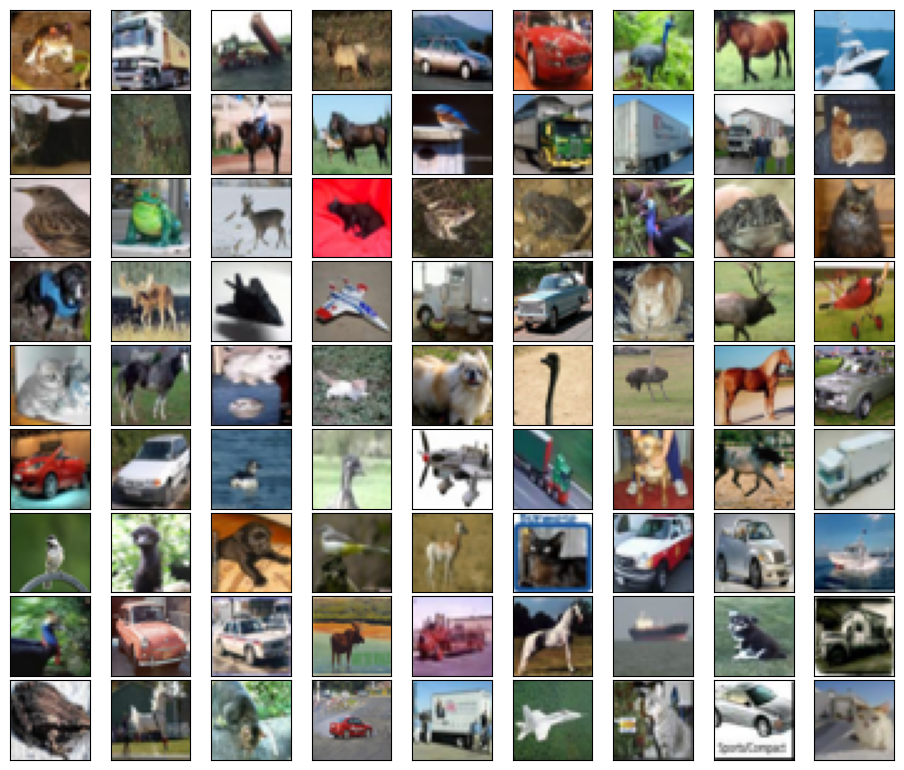

In [ ]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

# データセットの画像を可視化
i = 0
for x, _ in dataloader_train:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x)
    i += 1
    if i >= 81:
        break

## 2.Preprocessing

- Global Contrast Normalization (GCN)
- ZCA Whitening

### 2.1. Global Contrast Normalization (GCN)

$$ {\bf x}^{norm} = \frac{{\bf x} - \bar{{\bf x}}}{\sqrt{\sigma_{{\bf x}}}} $$

- 通常の標準化とは違い，画像ごとに行います．
- 可視化した際は（可視化に際してスケールを[0,1]化しているので）見た目に変化はありません．

In [ ]:
# 既存のGCNクラスは存在しないので自作
class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ


# 標準化後の画像を[0, 1]に正規化
def deprocess(x):
    """
    Argument
    --------
    x : np.ndarray
        入力画像．(H, W, C)

    Return
    ------
    _x : np.ndarray
        [0, 1]で正規化した画像．(H, W, C)
    """
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    return _x

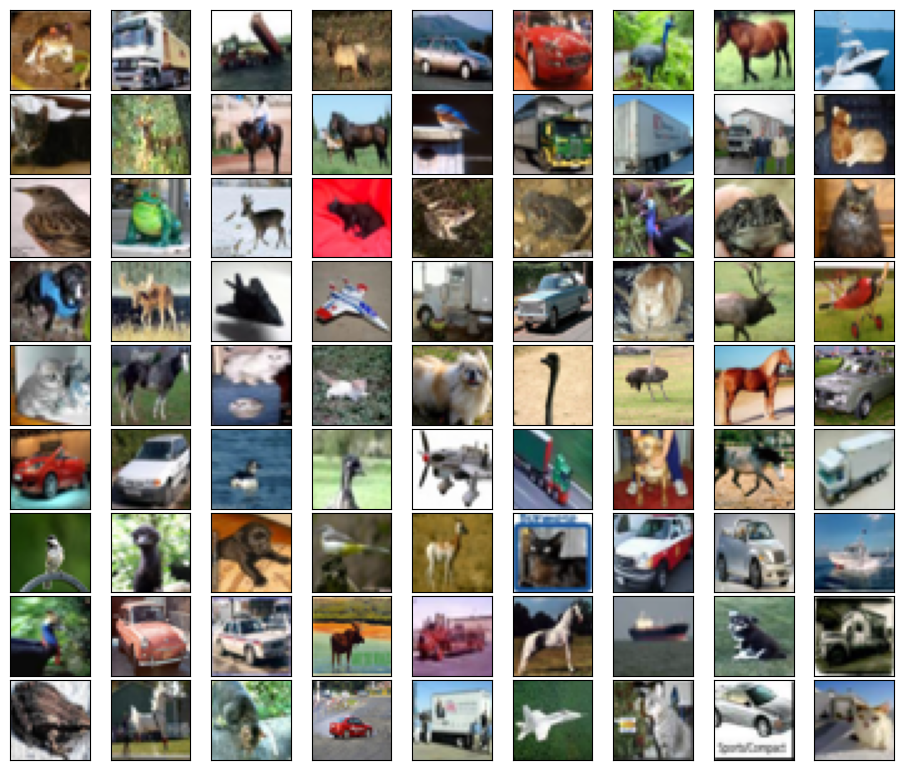

In [ ]:
GCN = gcn()
# transforms.Compose: データ拡張で行う処理を順番にまとめておく
transform_GCN = transforms.Compose([transforms.ToTensor(),
                                    GCN])  # PyTorchのTensor型にしてからGCNの処理を行う

dataloader_train_gcn = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=True, transform=transform_GCN),
    batch_size=batch_size,
    shuffle=False
)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

i = 0
for x, _ in dataloader_train_gcn:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(deprocess(x))
    i += 1
    if i >= 81:
        break

### 2.2. Zero-phase Component Analysis (ZCA) Whitening

$$ {\bf x}^{ZCA} = A(\Lambda + \epsilon I)^{-\frac{1}{2}} A^{\mathrm{T}} ({\bf x} - \bar{\bf x}) $$

- torch.linalg.eigh(対称行列用の固有値分解)を用いてZCAを実装しています．

In [ ]:
# ZCA白色化の実装
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):  # 計算が重いのでGPUを用いる
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        """
        Argument
        --------
        images : torchvision.datasets.cifar.CIFAR10
            入力画像（訓練データ全体）．(N, C, H, W)
        """
        x = images[0][0].reshape(1, -1)  # 画像（1枚）を1次元化
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)  # 平均値を格納するテンソル．xと同じ形状
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        # E: 固有値 V: 固有ベクトルを並べたもの
        E, V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())  # A(\Lambda + \epsilon I)^{1/2}A^T
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean  # x - \bar{x}
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x

In [ ]:
zca = ZCAWhitening()
images = datasets.CIFAR10('./data/cifar10', train=True, transform=transforms.ToTensor())
zca.fit(images)

0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


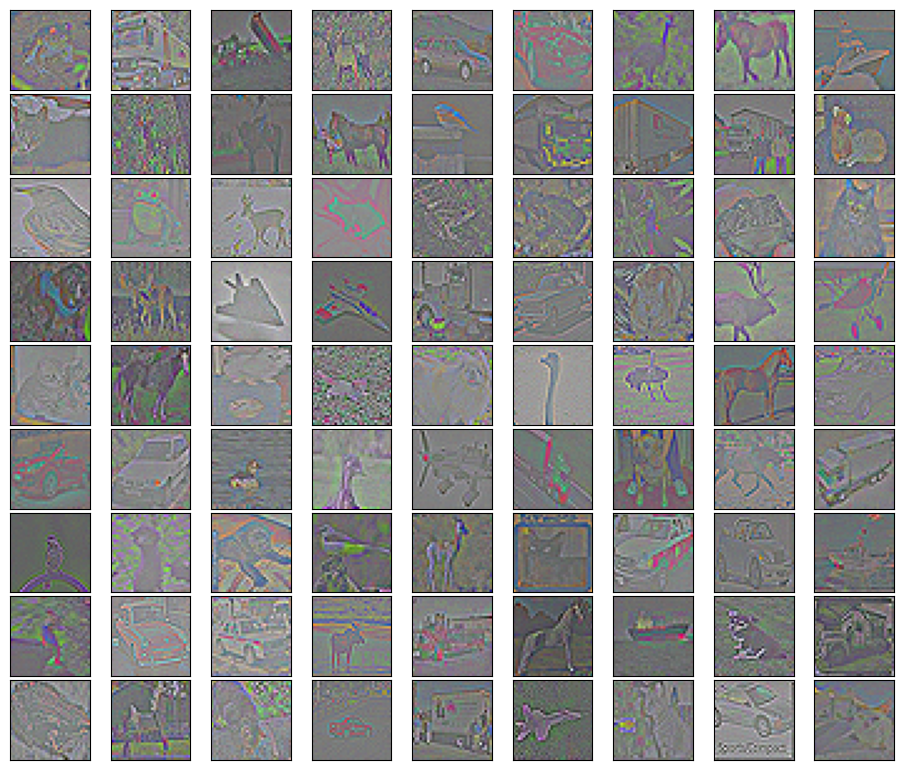

In [ ]:
transform_zca = transforms.Compose([transforms.ToTensor(),
                                    zca])

dataloader_train_zca = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', train=True, transform=transform_zca),
    batch_size=batch_size,
    shuffle=False
)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

i = 0
for x, _ in dataloader_train_zca:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(deprocess(x))
    i += 1
    if i >= 81:
        break

## 3.Batch Normalization

- 1ミニバッチ内の全データの同一チャネルをそれぞれ正規化する方法です．
- 深層学習において表現力の高さを保ちつつ，学習の収束の高速化と安定化に寄与します．

![](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png?w=1008)

（図の出典: http://proceedings.mlr.press/v37/ioffe15.html ）

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, shape, epsilon=np.float32(1e-5)):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(np.ones(shape, dtype='float32')))
        self.beta = nn.Parameter(torch.tensor(np.zeros(shape, dtype='float32')))
        self.epsilon = epsilon

    def forward(self, x):
        mean =  # WRITE ME  # torch.meanで平均を計算できる．また画像データでは，チャネルごとに計算
        std =  # WRITE ME  # torch.stdで標準偏差を計算できる
        x_normalized =  # WRITE ME
        return  # WRITE ME

## 4.Dropout

- 過学習を抑制する方法のひとつです．
- Dropoutは特定のレイヤーの出力を学習時にある確率`dropout_ratio`でシャットアウト(0に落とす)ことで，一部のデータが欠損していても正しく認識ができるようにします．
- これにより，画像の一部の局所特徴が過剰に評価されてしまうのを防ぎ，モデルのロバストさを向上させることができます．
- 推論時はすべてのニューロンを使います．そのため，学習時は `1 - dropout_ratio` の割合のニューロンしか使っていないのに，推論時はすべてのニューロンを使ったことによって出力が大きくなってしまうので，出力値に`1 - dropout_ratio`を乗算し，出力の大きさが学習時と同程度になるように調整します．

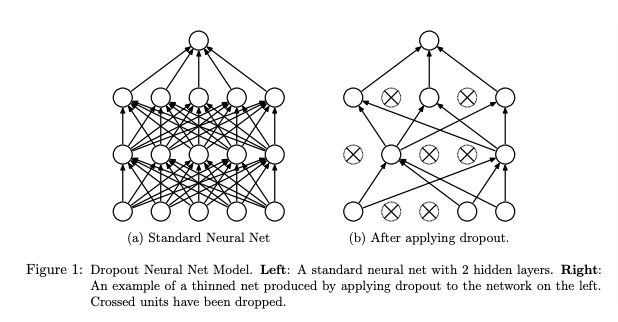

（図の出典：http://jmlr.org/papers/v15/srivastava14a.html
 ）

In [ ]:
class Dropout(nn.Module):
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        super().__init__()
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x):
        # 学習時はdropout_ratio分だけ出力をシャットアウト
        if self.training:
            self.mask = torch.rand(*x.size()) > self.dropout_ratio
            return x * self.mask.to(x.device)
        # 推論時は出力に`1.0 - self.dropout_ratio`を乗算することで学習時の出力の大きさに合わせる
        else:
            return x * (1.0 - self.dropout_ratio)

## 5.畳み込みニューラルネットワーク(Convolutional Neural Networks)の実装と学習

### 5.1. 各層クラスの実装

**畳み込み層**

In [ ]:
class Conv(nn.Module):
    def __init__(self, filter_shape, function=lambda x: x, stride=(1, 1), padding=0):
        super().__init__()
        # Heの初期化
        # filter_shape: (出力チャンネル数)x(入力チャンネル数)x(縦の次元数)x(横の次元数)
        fan_in = filter_shape[1] * filter_shape[2] * filter_shape[3]
        fan_out = filter_shape[0] * filter_shape[2] * filter_shape[3]

        self.W = nn.Parameter(torch.tensor(rng.normal(
                        0,
                        np.sqrt(2/fan_in),
                        size=filter_shape
                    ).astype('float32')))

        # バイアスはフィルタごとなので, 出力フィルタ数と同じ次元数
        self.b = nn.Parameter(torch.tensor(np.zeros((filter_shape[0]), dtype='float32')))

        self.function = function  # 活性化関数
        self.stride = stride  # ストライド幅
        self.padding = padding  # パディング

    def forward(self, x):
        u = F.conv2d(x, self.W, bias=self.b, stride=self.stride, padding=self.padding)
        return self.function(u)

**プーリング層**

In [ ]:
class Pooling(nn.Module):
    def __init__(self, ksize=(2, 2), stride=(2, 2), padding=0):
        super().__init__()
        self.ksize = ksize  # カーネルサイズ
        self.stride = stride  # ストライド幅
        self.padding = padding  # パディング

    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=self.ksize, stride=self.stride, padding=self.padding)

**平滑化層（4次元->2次元）**

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(x.size()[0], -1)

**全結合層**

In [ ]:
class Dense(nn.Module):
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        super().__init__()
        # Heの初期化
        # in_dim: 入力の次元数，out_dim: 出力の次元数

        self.W = nn.Parameter(torch.tensor(rng.normal(
                        0,
                        np.sqrt(2/in_dim),
                        size=(in_dim, out_dim)
                    ).astype('float32')))

        self.b = nn.Parameter(torch.tensor(np.zeros([out_dim]).astype('float32')))
        self.function = function

    def forward(self, x):
        return self.function(torch.matmul(x, self.W) + self.b)

**活性化層**

In [ ]:
class Activation(nn.Module):
    def __init__(self, function=lambda x: x):
        super().__init__()
        self.function = function

    def __call__(self, x):
        return self.function(x)

### 5.2. ネットワークの構築&データローダーの定義

**ネットワークの構築**

これまで定義してきた各層クラスを使用して，`conv_net`という変数に3層の畳み込み層をもつニューラル ネットワーク (ConvNet) を定義します．

In [ ]:
# torch.log(0)によるnanを防ぐ
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

In [ ]:
# ネットワークの定義
# WRITE ME(入出力の画像サイズ）のヒント: 特徴マップの幅，高さは((H - f + 2p) / s )+ 1
# H: 入力画像の幅，もしくは高さ f: フィルターの大きさ（幅方向，もしくは高さ方向） p: パディングサイズ s: ストライド幅
conv_net = nn.Sequential(
    Conv((32, 3, 3, 3)),        # WRITE ME(入出力の画像サイズ）
    BatchNorm((32, 30, 30)),
    Activation(F.relu),
    Pooling((2, 2)),            # WRITE ME(入出力の画像サイズ）
    Conv((64, 32, 3, 3)),       # WRITE ME(入出力の画像サイズ）
    BatchNorm((64, 13, 13)),
    Activation(F.relu),
    Pooling((2, 2)),            # WRITE ME(入出力の画像サイズ）
    Conv((128, 64, 3, 3)),      # WRITE ME(入出力の画像サイズ）
    BatchNorm((128, 4, 4)),
    Activation(F.relu),
    Pooling((2, 2)),            # WRITE ME(入出力の画像サイズ）
    Flatten(),
    Dense(# WRITE ME, 256, F.relu),  # 畳み込み層の出力を平坦化したものを入力している
    Dense(256, 10)
)


batch_size = 100
n_epochs = 10
lr = 0.01
device = 'cuda'

conv_net.to(device)
optimizer = optim.Adam(conv_net.parameters(), lr=lr)

**データローダーの定義**

CIFAR-10の画像をダウンロードし，train用，valid用にデータをランダムに分割します．

In [ ]:
trainval_dataset = datasets.CIFAR10('./data/cifar10', train=True, transform=transforms.ToTensor())

#zcaを定義
zca = ZCAWhitening()
zca.fit(trainval_dataset)

# 前処理を定義
transform = transforms.Compose([transforms.ToTensor(),
                                zca])

trainval_dataset = datasets.CIFAR10('./data/cifar10', train=True, transform=transform)

# trainとvalidに分割
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [len(trainval_dataset)-10000, 10000])

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

print("Train data number:{}, Valid data number: {}".format(len(train_dataset), len(val_dataset)))

0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!
Train data number:40000, Valid data number: 10000


### 5.3. 学習

In [ ]:
for epoch in range(n_epochs):
    losses_train = []  # 訓練誤差を格納しておくリスト
    losses_valid = []  # 検証データの誤差を格納しておくリスト

    conv_net.train()  # 訓練モードにする
    n_train = 0  # 訓練データ数
    acc_train = 0  # 訓練データに対する精度
    for x, t in dataloader_train:
        n_train += t.size()[0]

        conv_net.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動

        t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

        t = t.to(device)
        t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

        y = conv_net.forward(x)  # 順伝播

        loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    conv_net.eval()  # 評価モードにする
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動

        t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

        t = t.to(device)
        t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

        y = conv_net.forward(x)  # 順伝播

        loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))

EPOCH: 0, Train [Loss: 1.447, Accuracy: 0.483], Valid [Loss: 1.040, Accuracy: 0.632]
EPOCH: 1, Train [Loss: 0.881, Accuracy: 0.691], Valid [Loss: 0.901, Accuracy: 0.684]
EPOCH: 2, Train [Loss: 0.701, Accuracy: 0.754], Valid [Loss: 0.807, Accuracy: 0.723]
EPOCH: 3, Train [Loss: 0.591, Accuracy: 0.794], Valid [Loss: 0.759, Accuracy: 0.738]
EPOCH: 4, Train [Loss: 0.501, Accuracy: 0.827], Valid [Loss: 0.769, Accuracy: 0.752]
EPOCH: 5, Train [Loss: 0.422, Accuracy: 0.854], Valid [Loss: 0.778, Accuracy: 0.753]
EPOCH: 6, Train [Loss: 0.373, Accuracy: 0.869], Valid [Loss: 0.820, Accuracy: 0.751]
EPOCH: 7, Train [Loss: 0.314, Accuracy: 0.892], Valid [Loss: 0.866, Accuracy: 0.748]
EPOCH: 8, Train [Loss: 0.280, Accuracy: 0.902], Valid [Loss: 0.914, Accuracy: 0.751]
EPOCH: 9, Train [Loss: 0.237, Accuracy: 0.918], Valid [Loss: 0.939, Accuracy: 0.747]


## 6.Activationの可視化

各畳み込み層の特徴マップを可視化します．

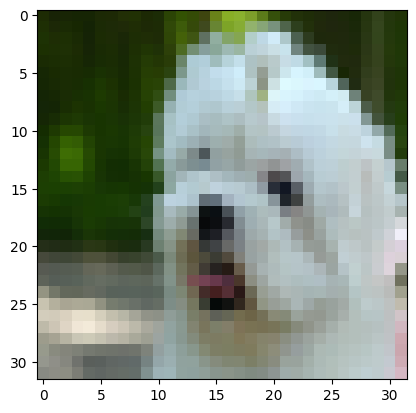

In [ ]:
trainval = datasets.CIFAR10('./data/cifar10')
image_id = 919  # 表示させる画像を選択
sample_image = trainval[image_id][0]
plt.imshow(sample_image)

In [ ]:
def feature_map(image, output_layer):  # output_layer番目の層の特徴マップを出力する関数
    """
    Argumnets
    ---------
    image : torch.Tensor
        入力画像．(C, H, W)
    output_layer : int
        表示したい特徴マップを出力する層の番号．

    Return
    ------
    image : torch.Tensor
        引数で設定した層から出力される特徴マップ．
    """
    image = transform(image)
    image = conv_net[0:output_layer + 1](image.unsqueeze(0).to(device))
    return image


print("ネットワークの構造")
print(conv_net)

ネットワークの構造
Sequential(
  (0): Conv()
  (1): BatchNorm()
  (2): Activation()
  (3): Pooling()
  (4): Conv()
  (5): BatchNorm()
  (6): Activation()
  (7): Pooling()
  (8): Conv()
  (9): BatchNorm()
  (10): Activation()
  (11): Pooling()
  (12): Flatten()
  (13): Dense()
  (14): Dense()
)


### 6.1. conv1

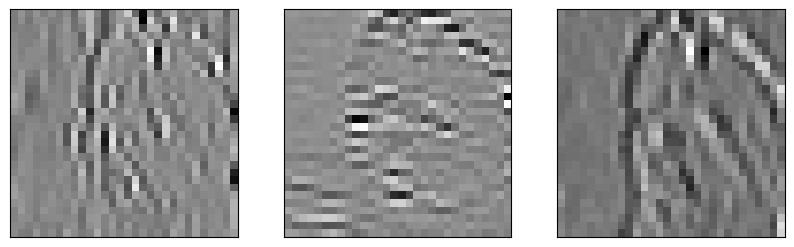

In [ ]:
_output = feature_map(sample_image, 0).to("cpu")
fig = plt.figure(figsize=(10, 10))
_output = np.transpose(torch.squeeze(_output).detach().numpy(), (1, 2, 0))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, xticks=[], yticks=[])
    ax.imshow(deprocess(_output[:, :, i]), cmap='gray')

### 6.2. conv2

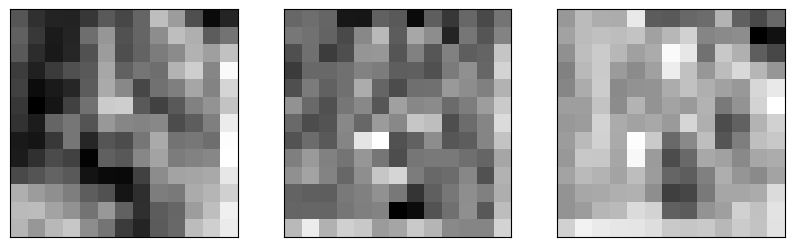

In [ ]:
_output = feature_map(sample_image, 4).to("cpu")
fig = plt.figure(figsize=(10, 10))
_output = np.transpose(torch.squeeze(_output).detach().numpy(), (1, 2, 0))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, xticks=[], yticks=[])
    ax.imshow(deprocess(_output[:, :, i]), cmap='gray')

### 6.3. conv3

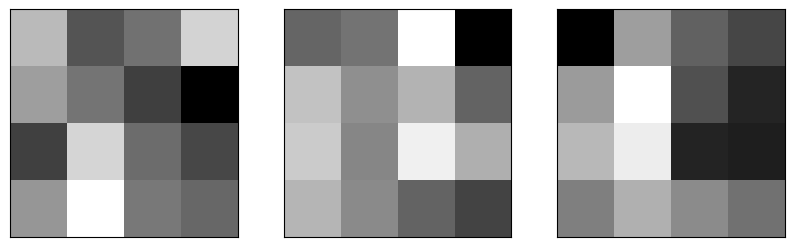

In [ ]:
_output = feature_map(sample_image, 8).to("cpu")
fig = plt.figure(figsize=(10, 10))
_output = np.transpose(torch.squeeze(_output).detach().numpy(), (1, 2, 0))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, xticks=[], yticks=[])
    ax.imshow(deprocess(_output[:, :, i]), cmap='gray')

学習後の特徴マップの性質として，浅い層はエッジなどの簡単な表現，深い層になるほど複雑な表現を獲得することが知られています．

参考: https://www.iro.umontreal.ca/~bengioy/talks/DL-Tutorial-NIPS2015.pdf (p.34)




## 7.torch.nn に含まれるlayer, Loss関数の利用

これまで扱ってきたPytorchの実装では比較的低レベルなAPIを使用してきました．それは本講義ではアルゴリズムの実装にフォーカスするためです．

しかしながら，実際にビジネスや研究で利用するときにはプリミティブな実装を一から書くのは手間になる場合もあります．そのような課題を解決するニーズに答え，Pytorchには高レベルなAPIも用意されています．その一つとして`torch.nn`に含まれるlayerやLoss関数があります．

ここまでは`torch.nn.Module`クラスを継承して様々なlayerを定義してきましたが，実は`torch.nn`に主要なlayer, Loss関数は含まれています．

ここでは，`torch.nn`に含まれるlayer, Loss関数を使って，課題5の畳み込みニューラルネットワークの実装を行ってみましょう．


なお，このような高レベルなAPIは簡単に実装できる反面，実装の柔軟性が落ちるという欠点もあります．場合によって使い分ける必要があります．

`torch.nn`で使えるモジュールは以下のページで確認できます．

[Module: torch.nn](https://pytorch.org/docs/stable/nn.html)

一般的なレイヤーは一通り揃っています．

```python
# 線形層
nn.Linear(input_dim, output_dim)

# 畳み込み層
nn.Conv2d(input_dim, output_dim, kernel_size)

# LSTM（詳細は次週）
nn.LSTM(input_dim, hidden_dim, num_layers)

...
```

一般的な誤差関数も一通り揃っています．

```python
# L1誤差
nn.L1Loss()

# 平均二乗誤差
nn.MSELoss()

# 交差エントロピー誤差
nn.CrossEntropyLoss()

...
```

### 7.1. ネットワークの構築&データローダーの定義

**ネットワークの構築**

In [ ]:
conv_net2 = nn.Sequential(
    nn.Conv2d(3, 32, 3),              # 32x32x3 -> 30x30x32
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 30x30x32 -> 15x15x32
    nn.Conv2d(32, 64, 3),             # 15x15x32 -> 13x13x64
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 13x13x64 -> 6x6x64
    nn.Conv2d(64, 128, 3),            # 6x6x64 -> 4x4x128
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 4x4x128 -> 2x2x128
    nn.Flatten(),
    nn.Linear(2*2*128, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)


def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)


conv_net2.apply(init_weights)

batch_size = 100
n_epochs = 5
lr = 0.01
device = 'cuda'

conv_net2.to(device)
optimizer2 = optim.Adam(conv_net2.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()  # nn.ClossEntropyLossは，出力のsoftmax変換と，正解ラベルのone-hot vector化の機能を持っている

**データローダーの定義**

In [ ]:
trainval_dataset = datasets.CIFAR10('./data/cifar10', train=True, transform=transforms.ToTensor())

#zcaを定義
zca = ZCAWhitening()
zca.fit(trainval_dataset)

# 前処理を定義
transform = transforms.Compose([transforms.ToTensor(),
                                zca])

trainval_dataset = datasets.CIFAR10('./data/cifar10', train=True, transform=transform)

# trainとvalidに分割
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [len(trainval_dataset)-10000, 10000])

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


### 7.2. 学習

In [ ]:
for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    conv_net2.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]

        conv_net2.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = conv_net2.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer2.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    conv_net2.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = conv_net2.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))

EPOCH: 0, Train [Loss: 1.435, Accuracy: 0.493], Valid [Loss: 1.277, Accuracy: 0.543]
EPOCH: 1, Train [Loss: 0.902, Accuracy: 0.684], Valid [Loss: 0.934, Accuracy: 0.669]
EPOCH: 2, Train [Loss: 0.723, Accuracy: 0.750], Valid [Loss: 0.831, Accuracy: 0.721]
EPOCH: 3, Train [Loss: 0.621, Accuracy: 0.785], Valid [Loss: 0.800, Accuracy: 0.730]
EPOCH: 4, Train [Loss: 0.538, Accuracy: 0.813], Valid [Loss: 0.890, Accuracy: 0.727]
